# Section 1 Implementation of the RBF-Net

Importimg necessary modules

In [67]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from keras                   import backend as K
from keras.layers            import Layer
from keras.initializers      import RandomUniform, Initializer, Constant
from keras.initializers      import Initializer
from sklearn.cluster         import KMeans, AffinityPropagation, MeanShift, DBSCAN
from keras.models            import Sequential 
from keras.layers            import Dense
from keras.layers            import Activation
from keras.optimizers        import RMSprop
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from DB_Scan                 import db_scan

Defining custom RBF-Layer class

In [68]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0) #initialization of basis functions
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name        = 'centers',
                                       shape       = (self.output_dim, input_shape[1]),
                                       initializer = self.initializer,
                                       trainable   = True)
        self.betas   = self.add_weight(name        = 'betas',
                                       shape       = (self.output_dim,),
                                       initializer = Constant(value=self.init_betas),
                                       trainable   = True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        print('call return',K.exp(-self.betas * K.sum(H**2, axis=1)))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Defining Center Initializer

In [69]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        #KM
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        #AF
        af = AffinityPropagation()
        af.fit_predict(self.X)
        #MS
        ms= MeanShift()
        ms.fit_predict(self.X)
        #DBSCAN
        db_cluster = db_scan(0.1,5,self.X)
        return km.cluster_centers_

Loading and Preparing Data 

In [70]:
#data Loading
# data = pd.read_csv('olive.csv',header=None)
# datatrans=np.transpose(data)

# #af and pca initialization
pca = PCA(n_components=12)

# # #data spliting
# X = data.iloc[2:570,:].values
# y = data.iloc[0:1,:].values

# #data rotation
# X=np.transpose(X)
# y=np.transpose(y)

# iris dataset
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits

data =  load_digits() #load_wine()
X = data.data
y = data.target
y=y.reshape(y.shape[0],1)

#standarizing
X = MinMaxScaler().fit_transform(X)

X = pca.fit_transform(X)
print(X)
print(y)

#one hot encoding targets
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=0)

[[ 0.06113647  1.37811761 -0.53875454 ...  0.22563804  0.16716901
   0.09523818]
 [ 0.37573653 -1.35465668  0.22696229 ... -0.07656029 -0.3585166
  -0.11268613]
 [ 0.37051511 -0.67598779  0.16866214 ...  0.28103386 -0.09201258
  -0.03032918]
 ...
 [ 0.61312441 -0.52194204  0.35380538 ... -0.80640306  0.53607536
   0.22963245]
 [-0.23032125  0.82528372 -0.59847939 ... -0.79606354  0.23827704
   0.07152255]
 [-0.02290088  0.34818109  0.70369696 ... -0.76713568  0.74028609
   0.3326737 ]]
[[0]
 [1]
 [2]
 ...
 [8]
 [9]
 [8]]


Building model

In [71]:
model = Sequential()
rbflayer = RBFLayer(24, initializer=InitCentersKMeans(X_train), betas=3.0, input_shape=(X.shape[1],))
model.add(rbflayer)
model.add(Dense(10))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',optimizer=RMSprop(), metrics=['accuracy'])
print(model.summary())
initial_weights=model.get_weights()[0]
history1 = model.fit(X_train, y_train, epochs=2000, batch_size=64,verbose=0)

c:\Users\fabia\miniconda3\envs\DMAML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fabia\miniconda3\envs\DMAML\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


call return Tensor("rbf_layer_6/Exp:0", shape=(None, 24), dtype=float32)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_6 (RBFLayer)      (None, 24)                312       
                                                                 
 dense_6 (Dense)             (None, 10)                250       
                                                                 
 activation_6 (Activation)   (None, 10)                0         
                                                                 
Total params: 562 (2.20 KB)
Trainable params: 562 (2.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
call return Tensor("sequential_6/rbf_layer_6/Exp:0", shape=(None, 24), dtype=float32)
call return Tensor("sequential_6/rbf_layer_6/Exp:0", shape=(None, 24), dtype=float32)


Training evaluation

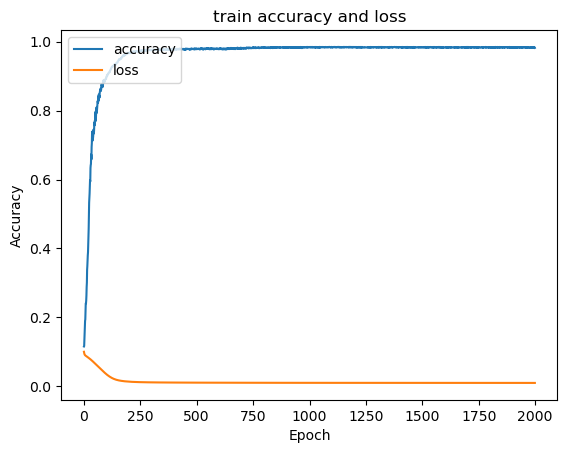

[0.11551844328641891, 0.11691022664308548, 0.13569937646389008, 0.15170493721961975, 0.17536534368991852, 0.18997912108898163, 0.19415448606014252, 0.2247738391160965, 0.24077939987182617, 0.24077939987182617, 0.24843423068523407, 0.2630480229854584, 0.2881002128124237, 0.30062630772590637, 0.33820459246635437, 0.3486430048942566, 0.36882394552230835, 0.37995824217796326, 0.3890048861503601, 0.4077940285205841, 0.4349339008331299, 0.45859429240226746, 0.4982602596282959, 0.5330549478530884, 0.5462769865989685, 0.5588030815124512, 0.5831593871116638, 0.5977731347084045, 0.5942936539649963, 0.6332637667655945, 0.6416144967079163, 0.6450939178466797, 0.6729297041893005, 0.6583159565925598, 0.6945024132728577, 0.705636739730835, 0.736952006816864, 0.7390396595001221, 0.7125957012176514, 0.7327766418457031, 0.719554603099823, 0.7258176803588867, 0.7446067929267883, 0.7404314279556274, 0.7334725260734558, 0.743215024471283, 0.7654836177825928, 0.757132887840271, 0.7703549265861511, 0.7696589

In [72]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])
plt.title('train accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()
print(history1.history['accuracy'])

Test evaluation

In [73]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss:", results[0])
print("test accuracy:",results[1]*100,'%')
y_pred = model.predict(X_test)

Evaluate on test data
call return Tensor("sequential_6/rbf_layer_6/Exp:0", shape=(None, 24), dtype=float32)
12/12 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.9611
test loss: 0.012396307662129402
test accuracy: 96.11111283302307 %
call return Tensor("sequential_6/rbf_layer_6/Exp:0", shape=(None, 24), dtype=float32)
12/12 [==============================] - 0s 1ms/step


Generating test metrics

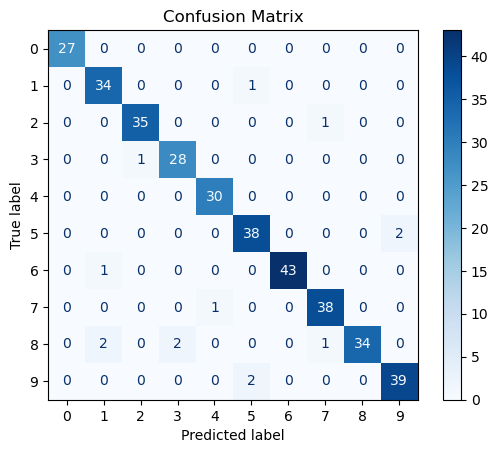

Test Accuracy is: 96.11111111111111


In [74]:
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

    
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

a    = accuracy_score(pred,test)
cfn  = confusion_matrix(test,pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cfn)#, display_labels= ['Class 0', 'Class 1','Class 2'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
print('Test Accuracy is:', a*100)

Helper function for visual feedback

In [75]:
def plot_circle(center, radius,axis):
    theta = np.linspace(0, 2*np.pi, 100)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    axis.plot(x, y,c='m')

Plotting the resulting basis functions and the training + test data

Plotting RBF's with the train data (downscaled beta by 5)

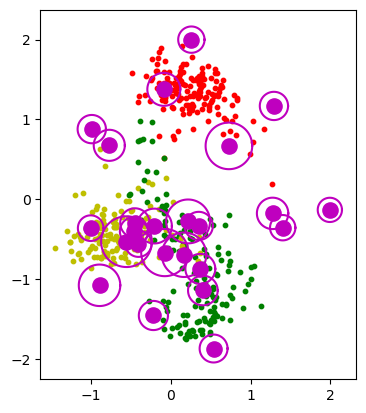

In [76]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for k in range(rbflayer.centers.shape[0]):
    ax1.scatter(rbflayer.centers[k][0],rbflayer.centers[k][1],s=120, c='m', marker="o",zorder=2)
    plot_circle(rbflayer.centers[k],np.sqrt(2*rbflayer.betas[k])/5,ax1)

# for k in range(initial_weights.shape[0]):
#     ax1.scatter(initial_weights[k][0],initial_weights[k][1],s=120, c='k', marker="o",zorder=2)
#     #plot_circle(rbflayer.centers[k],np.sqrt(2*rbflayer.betas[k])/5,ax1)

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i]) == 0:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='r', marker="o", label='second')
    if np.argmax(y_train[i]) == 1:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='g', marker="o", label='second')
    if np.argmax(y_train[i]) == 2:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='y', marker="o", label='second')

ax1.set_aspect('equal', adjustable='box')

plt.show()

Plotting RBF's with training data (downscaled beta by 5)

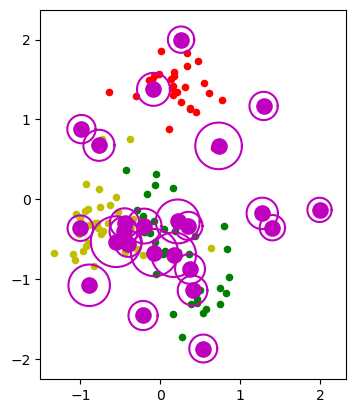

In [77]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for k in range(rbflayer.centers.shape[0]):
    ax1.scatter(rbflayer.centers[k][0],rbflayer.centers[k][1],s=120, c='m', marker="o",zorder=2)
    plot_circle(rbflayer.centers[k],np.sqrt(2*rbflayer.betas[k])/5,ax1)



for i in range(X_test.shape[0]):
    if np.argmax(y_test[i]) == 0:
        ax1.scatter(X_test[i,0],X_test[i,1], s=20, c='r', marker="o", label='second')
    if np.argmax(y_test[i]) == 1:
        ax1.scatter(X_test[i,0],X_test[i,1], s=20, c='g', marker="o", label='second')
    if np.argmax(y_test[i]) == 2:
        ax1.scatter(X_test[i,0],X_test[i,1], s=20, c='y', marker="o", label='second')
ax1.set_aspect('equal', adjustable='box')

plt.show()

Plotting center shift over training

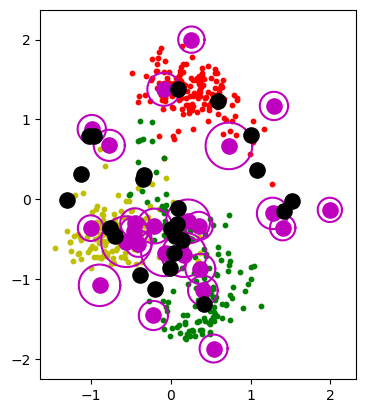

In [78]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for k in range(rbflayer.centers.shape[0]):
    ax1.scatter(rbflayer.centers[k][0],rbflayer.centers[k][1],s=120, c='m', marker="o",zorder=2)
    plot_circle(rbflayer.centers[k],np.sqrt(2*rbflayer.betas[k])/5,ax1)

for k in range(initial_weights.shape[0]):
    ax1.scatter(initial_weights[k][0],initial_weights[k][1],s=120, c='k', marker="o",zorder=2)

for i in range(X_train.shape[0]):
    if np.argmax(y_train[i]) == 0:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='r', marker="o", label='second')
    if np.argmax(y_train[i]) == 1:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='g', marker="o", label='second')
    if np.argmax(y_train[i]) == 2:
        ax1.scatter(X_train[i,0],X_train[i,1], s=10, c='y', marker="o", label='second')
    
ax1.set_aspect('equal', adjustable='box')

plt.show()